In [17]:
# Install required packages
!pip install -q requests networkx matplotlib geopy folium seaborn flexpolyline scikit-learn osmnx elevation python-dotenv requests_cache haversine

# Import necessary libraries
import os
import time
import math
import json
import warnings
import logging
import requests
import requests_cache
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import folium
from folium.plugins import HeatMap, MarkerCluster
import flexpolyline
import osmnx as ox
from geopy.distance import geodesic
from datetime import datetime
from sklearn.neighbors import KDTree
import haversine as hs
from IPython.display import display, HTML

# Configure logging for debugging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('ev_routing_advanced')

# Set plot styling
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

# Ignore certain warnings
warnings.filterwarnings("ignore", category=FutureWarning)
requests_cache.install_cache('ev_routing_cache', expire_after=86400) # Cache for 24 hours

print("Libraries imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.8 MB/s eta 0:00:00
Libraries imported successfully!


In [18]:
# Load environment variables
load_dotenv()

# HERE Maps API credentials - Use env variable or default to a placeholder
HERE_API_KEY = os.getenv("HERE_API_KEY", "_ndbqeeFBj4CO61Ygrbm0duIGwVPbWIm6Mp8_GvgD9A")

# Open Elevation API
OPEN_ELEVATION_API = "https://api.open-elevation.com/api/v1/lookup"

# Example origin-destination pair in Lyon, France (latitude,longitude format)
origin = "45.77031773045832,4.797116290985852"
destination = "45.76469668270752,4.955347272776582"

# Vehicle parameters based on Nissan Leaf model (as referenced in the paper)
vehicle_params = {
    # Physical parameters
    "mass": 1520,  # kg - vehicle mass with driver
    "frontal_area": 2.27,  # m² - frontal area
    "drag_coefficient": 0.29,  # drag coefficient (dimensionless)
    "wheel_radius": 0.31,  # meters - wheel radius
    "rho_air": 1.225,  # kg/m³ - air density at sea level
    "gravity": 9.81,  # m/s² - gravitational acceleration

    # Rolling resistance coefficients (as in the paper)
    "a0": 0.0135,  # Rolling resistance coefficient (dimensionless)

    # Drivetrain parameters
    "transmission_ratio": 7.94,  # transmission ratio
    "transmission_efficiency": 0.98,  # transmission efficiency (dimensionless)
    "drive_efficiency": {
        "motoring": 0.91,  # efficiency during motoring/traction
        "regeneration": 0.82  # efficiency during regeneration
    },

    # Motor characteristics
    "motor_max_torque": 254,  # Nm - maximum torque
    "motor_min_torque": -254,  # Nm - minimum (regenerative) torque
    "motor_max_power": 80000,  # W - maximum power
    "regen_efficiency": 0.25,  # Proportion of energy recovered during regenerative braking

    # Battery characteristics
    "battery_capacity": 40,  # kWh - total capacity
    "battery_voltage": 360,  # V - nominal voltage

    # Speed limits for efficient operation
    "optimal_speed_range": (40, 60),  # km/h - optimal speed range for energy efficiency

    # Traffic model parameters (custom)
    "congestion_penalty": 1.2,  # Energy multiplier for congested segments
    "peak_hours": [(7, 9), (16, 19)]  # Morning and evening peak hours (24h format)
}

# Default acceleration and deceleration values
default_accel = 0.5  # m/s²
default_decel = -1.0  # m/s²

print("Configuration loaded successfully.")

Configuration loaded successfully.


In [19]:
def fetch_elevation(coordinates, batch_size=100):
    """
    Fetch elevation data for coordinates using Open-Elevation API.

    Parameters:
    -----------
    coordinates : list
        List of (lat, lon) tuples
    batch_size : int
        Size of batches for API requests

    Returns:
    --------
    list
        List of elevations in meters for each coordinate
    """
    all_elevations = []

    # Process in batches to avoid large requests
    for i in range(0, len(coordinates), batch_size):
        batch = coordinates[i:i+batch_size]

        # Prepare the request payload
        locations = [{"latitude": lat, "longitude": lon} for lat, lon in batch]
        payload = {"locations": locations}

        try:
            response = requests.post(OPEN_ELEVATION_API, json=payload)
            if response.status_code == 200:
                data = response.json()
                elevations = [result["elevation"] for result in data["results"]]
                all_elevations.extend(elevations)
            else:
                # Fallback: use a simple model for missing elevations
                logger.warning(f"Elevation API error: {response.status_code}. Using fallback.")
                all_elevations.extend([0] * len(batch))  # Assume flat terrain as fallback
        except Exception as e:
            logger.error(f"Error fetching elevations: {e}")
            all_elevations.extend([0] * len(batch))  # Fallback

    return all_elevations

def calculate_road_grade(point1, point2, elev1, elev2):
    """
    Calculate road grade (slope) between two points.

    Parameters:
    -----------
    point1 : tuple
        First point (lat, lon)
    point2 : tuple
        Second point (lat, lon)
    elev1 : float
        Elevation at first point
    elev2 : float
        Elevation at second point

    Returns:
    --------
    float
        Road grade as decimal (rise/run)
    """
    # Calculate horizontal distance using Haversine formula
    distance_m = hs.haversine(point1, point2, unit=hs.Unit.METERS)

    # Prevent division by zero
    if distance_m < 0.1:  # If points are very close
        return 0.0

    # Calculate elevation change
    elev_change = elev2 - elev1

    # Calculate grade (rise/run)
    grade = elev_change / distance_m

    # Clip to reasonable range (-0.15 to 0.15 ~ -15% to 15%)
    return max(min(grade, 0.15), -0.15)

# Test elevation retrieval for a sample coordinate
test_coords = [(float(origin.split(',')[0]), float(origin.split(',')[1]))]
test_elevation = fetch_elevation(test_coords)
print(f"Sample elevation at origin: {test_elevation[0]} meters")

Sample elevation at origin: 174.0 meters


In [21]:
def get_route_data(origin, destination, routing_mode, departure_time=None, retries=3, backoff_factor=2):
    """
    Retrieve routing data from HERE Maps API with traffic information.

    Parameters:
    -----------
    origin : str
        Origin coordinates in 'latitude,longitude' format
    destination : str
        Destination coordinates in 'latitude,longitude' format
    routing_mode : str
        Routing mode ('fast' for fastest, 'short' for shortest)
    departure_time : str
        Optional departure time in ISO format
    retries : int
        Number of retry attempts for API calls
    backoff_factor : int
        Factor to increase wait time between retries

    Returns:
    --------
    dict
        JSON response containing route information
    """
    url = "https://router.hereapi.com/v8/routes"

    params = {
        "apikey": HERE_API_KEY,
        "transportMode": "car",
        "origin": origin,
        "destination": destination,
        "routingMode": routing_mode,
        "return": "summary,polyline,actions,instructions,travelSummary",
        "spans": "speedLimit,length,duration,streetAttributes"
    }

    # Add traffic information if departure time is provided
    if departure_time:
        params["departureTime"] = departure_time

    for attempt in range(retries):
        try:
            logger.info(f"API request ({routing_mode} route) - Attempt {attempt+1}/{retries}")
            response = requests.get(url, params=params, timeout=30)

            if response.status_code == 200:
                route_data = response.json()
                if 'routes' in route_data and len(route_data['routes']) > 0:
                    summary = route_data['routes'][0]['sections'][0]['summary']
                    travel_time_seconds = summary['duration']
                    travel_distance_meters = summary['length']
                    logger.info(f"{routing_mode.capitalize()} route: {travel_distance_meters:.2f}m, {travel_time_seconds:.2f}s")
                    return route_data
                else:
                    logger.warning("No route found between the specified origin and destination.")
                    return None
            elif response.status_code == 429:  # Too Many Requests
                wait_time = backoff_factor ** attempt
                logger.warning(f"Rate limited. Waiting {wait_time} seconds before retry.")
                time.sleep(wait_time)
            else:
                logger.error(f"API Error: {response.status_code} - {response.text}")
                if attempt == retries - 1:  # Last attempt
                    raise Exception(f"HERE Maps API request failed with status code {response.status_code}")
                time.sleep(backoff_factor ** attempt)
        except requests.exceptions.RequestException as e:
            logger.error(f"Request error: {e}")
            if attempt == retries - 1:  # Last attempt
                raise
            time.sleep(backoff_factor ** attempt)

    return None  # If all retries fail

# Test the route data retrieval
try:
    # Format current time in ISO 8601 format without microseconds
    current_time = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

    # First try without departure time (which should work)
    print("Retrieving routes without traffic information...")
    fastest_route = get_route_data(origin, destination, routing_mode="fast")
    shortest_route = get_route_data(origin, destination, routing_mode="short")

    # Optional: Try with departure time if needed
    # print("Retrieving routes with traffic information...")
    # fastest_route_with_traffic = get_route_data(origin, destination, routing_mode="fast", departure_time=current_time)
    # shortest_route_with_traffic = get_route_data(origin, destination, routing_mode="short", departure_time=current_time)

    if fastest_route and shortest_route:
        print("✅ Route data retrieved successfully")

        # Extract segment data
        fastest_segments = extract_segment_data(fastest_route)
        shortest_segments = extract_segment_data(shortest_route)

        print(f"Extracted {len(fastest_segments)} segments from fastest route")
        print(f"Extracted {len(shortest_segments)} segments from shortest route")
    else:
        print("❌ Failed to retrieve route data")

except Exception as e:
    print(f"Error: {str(e)}")

Retrieving routes without traffic information...
✅ Route data retrieved successfully
Extracted 361 segments from fastest route
Extracted 391 segments from shortest route


In [22]:
def compute_energy_consumption(segments, vehicle_params, with_elevations=True):
    """
    Calculate energy consumption for route segments using a detailed EV energy model.

    Parameters:
    -----------
    segments : list
        List of segment dictionaries with properties
    vehicle_params : dict
        Dictionary of vehicle parameters
    with_elevations : bool
        Whether to fetch and use elevation data

    Returns:
    --------
    tuple
        (energy_consumption_list, total_energy_kwh, segments_with_energy)
    """
    # Extract all coordinates for batch elevation query
    if with_elevations:
        all_coords = []
        for segment in segments:
            all_coords.append(segment['start'])
        all_coords.append(segments[-1]['end'])  # Add the last endpoint

        # Fetch elevations for all points
        elevations = fetch_elevation(all_coords)

        # Add elevations to segments
        for i, segment in enumerate(segments):
            segment['start_elevation'] = elevations[i]
            segment['end_elevation'] = elevations[i+1]

            # Calculate grade
            segment['grade'] = calculate_road_grade(
                segment['start'], segment['end'],
                segment['start_elevation'], segment['end_elevation']
            )
    else:
        # Use flat terrain assumption
        for segment in segments:
            segment['grade'] = 0.0

    # Calculate energy consumption for each segment
    energy_consumption = []
    segments_with_energy = []

    for segment in segments:
        # Extract segment properties
        length = segment['length']  # meters
        speed = segment['speed']    # m/s
        grade = segment['grade']    # decimal

        # Determine if acceleration or deceleration is needed
        if 'next_speed' in segment:
            acceleration = (segment['next_speed'] - speed) / segment['duration'] if segment['duration'] > 0 else 0
        else:
            acceleration = 0  # Assume constant speed

        # Apply congestion factor if segment is congested
        if segment.get('is_congested', False):
            energy_factor = vehicle_params['congestion_penalty']
        else:
            energy_factor = 1.0

        # Get motion forces
        f_rolling = vehicle_params['mass'] * vehicle_params['gravity'] * vehicle_params['a0'] * math.cos(math.atan(grade))
        f_aero = 0.5 * vehicle_params['rho_air'] * vehicle_params['frontal_area'] * vehicle_params['drag_coefficient'] * (speed**2)
        f_grade = vehicle_params['mass'] * vehicle_params['gravity'] * math.sin(math.atan(grade))
        f_accel = vehicle_params['mass'] * acceleration

        # Total tractive force
        f_traction = f_rolling + f_aero + f_grade + f_accel

        # Power at wheels
        wheel_power = f_traction * speed

        # Convert to motor power
        if wheel_power >= 0:  # Motoring mode (consuming energy)
            motor_power = wheel_power / vehicle_params['transmission_efficiency']
            battery_power = motor_power / vehicle_params['drive_efficiency']['motoring']
        else:  # Regeneration mode (recovering energy)
            # Apply regeneration efficiency limits
            regen_power = wheel_power * vehicle_params['transmission_efficiency']
            # Limit regenerative braking power based on motor limits and regen efficiency
            regen_power = max(regen_power, -vehicle_params['motor_max_power'] * vehicle_params['regen_efficiency'])
            battery_power = regen_power * vehicle_params['drive_efficiency']['regeneration']

        # Calculate energy for this segment (Watt-seconds or Joules)
        travel_time = segment['duration']
        energy_joules = battery_power * travel_time

        # Apply congestion factor (more frequent stops, inefficient speeds)
        energy_joules *= energy_factor

        # Convert to kWh (1 J = 2.77778e-7 kWh)
        energy_kwh = energy_joules / 3_600_000

        # Store calculated energy
        energy_consumption.append(energy_kwh)

        # Add energy to segment data
        segment['energy_kwh'] = energy_kwh
        segments_with_energy.append(segment)

    # Calculate total energy (kWh)
    total_energy_kwh = sum(energy_consumption)

    return energy_consumption, total_energy_kwh, segments_with_energy

# Test energy consumption calculation
if 'fastest_segments' in locals():
    energy_list, total_energy, segments_with_energy = compute_energy_consumption(
        fastest_segments[:10],  # Use first 10 segments as a sample
        vehicle_params
    )

    print(f"Energy consumption for sample segments: {total_energy:.5f} kWh")
    print(f"Individual segment energy values: {[f'{e:.6f}' for e in energy_list[:3]]}...")

Energy consumption for sample segments: 0.03899 kWh
Individual segment energy values: ['0.003419', '0.002590', '0.002292']...


In [23]:
def build_detailed_road_network(segments, energy_data=None):
    """
    Build a detailed road network graph from route segments.

    Parameters:
    -----------
    segments : list
        List of road segments with properties
    energy_data : list
        Optional list of energy consumption values for each segment

    Returns:
    --------
    networkx.DiGraph
        Directed graph with energy costs as edge weights
    """
    # Create a new directed graph
    graph = nx.DiGraph()

    logger.info("Building detailed road network graph...")

    # Add nodes and edges to the graph
    for i, segment in enumerate(segments):
        start_node = tuple(segment['start'])  # (lat, lng) tuple
        end_node = tuple(segment['end'])      # (lat, lng) tuple

        # Add nodes if they don't exist yet
        if start_node not in graph:
            graph.add_node(start_node, pos=(start_node[1], start_node[0]))  # (lng, lat) for visualization

        if end_node not in graph:
            graph.add_node(end_node, pos=(end_node[1], end_node[0]))  # (lng, lat) for visualization

        # Determine edge attributes
        length = segment['length']
        duration = segment['duration']

        # Use pre-calculated energy if available, otherwise use length as proxy
        if 'energy_kwh' in segment:
            energy = segment['energy_kwh']
        elif energy_data and i < len(energy_data):
            energy = energy_data[i]
        else:
            # Fallback energy model (simple approximation)
            energy = length * 0.0001  # Simplified energy model

        # Add edge with attributes
        graph.add_edge(
            start_node,
            end_node,
            weight=energy,          # Primary weight for routing is energy
            length=length,          # Length in meters
            time=duration,          # Travel time in seconds
            grade=segment.get('grade', 0),  # Road grade if available
            speed=segment.get('speed', 0),  # Speed in m/s
            congested=segment.get('is_congested', False)  # Congestion flag
        )

    logger.info(f"Built graph with {len(graph.nodes)} nodes and {len(graph.edges)} edges")
    return graph

def find_closest_node(graph, target_coords):
    """
    Find the closest node in the graph to the target coordinates.

    Parameters:
    -----------
    graph : networkx.DiGraph
        Graph containing nodes with coordinate data
    target_coords : tuple or list
        Target coordinates (lat, lng)

    Returns:
    --------
    tuple
        Closest node coordinates
    """
    if not graph.nodes:
        logger.error("Graph has no nodes")
        return None

    if isinstance(target_coords, str):
        # Convert from "lat,lng" format to tuple
        lat, lng = map(float, target_coords.split(','))
        target_coords = (lat, lng)

    # Create a KDTree for efficient nearest neighbor search
    nodes = list(graph.nodes())
    kd_tree = KDTree(nodes)

    # Find closest node
    _, idx = kd_tree.query([target_coords], k=1)
    closest_node = nodes[idx[0][0]]

    # Calculate distance to check if it's reasonable
    dist = geodesic(closest_node, target_coords).meters
    logger.debug(f"Closest node to {target_coords} is {closest_node} (distance: {dist:.2f}m)")

    return closest_node

# Build graphs from the route segments
if 'fastest_segments' in locals() and 'shortest_segments' in locals():
    # First, compute energy consumption for both routes
    _, fastest_energy_total, fastest_segments_with_energy = compute_energy_consumption(
        fastest_segments, vehicle_params, with_elevations=True
    )

    _, shortest_energy_total, shortest_segments_with_energy = compute_energy_consumption(
        shortest_segments, vehicle_params, with_elevations=True
    )

    # Build detailed graphs
    fastest_graph = build_detailed_road_network(fastest_segments_with_energy)
    shortest_graph = build_detailed_road_network(shortest_segments_with_energy)

    # Combine the graphs to get more routing options
    combined_graph = nx.compose(fastest_graph, shortest_graph)

    print(f"Built 3 graphs:")
    print(f"  - Fastest route graph: {len(fastest_graph.nodes)} nodes, {len(fastest_graph.edges)} edges")
    print(f"  - Shortest route graph: {len(shortest_graph.nodes)} nodes, {len(shortest_graph.edges)} edges")
    print(f"  - Combined graph: {len(combined_graph.nodes)} nodes, {len(combined_graph.edges)} edges")

Built 3 graphs:
  - Fastest route graph: 362 nodes, 361 edges
  - Shortest route graph: 392 nodes, 391 edges
  - Combined graph: 640 nodes, 640 edges


In [24]:
def energy_efficient_route_finder(graph, origin, destination, weight='weight'):
    """
    Find the energy-efficient path using modified Dijkstra's algorithm.

    Parameters:
    -----------
    graph : networkx.DiGraph
        Directed graph with energy costs as edge weights
    origin : tuple
        Origin coordinates (lat, lng)
    destination : tuple
        Destination coordinates (lat, lng)
    weight : str
        Edge attribute to use as weight (default: 'weight' = energy)

    Returns:
    --------
    tuple
        (path, total_energy, total_distance, total_time)
    """
    try:
        # Find closest nodes to origin and destination
        origin_node = find_closest_node(graph, origin)
        destination_node = find_closest_node(graph, destination)

        if origin_node is None or destination_node is None:
            logger.error("Could not find matching nodes for origin or destination")
            return [], 0, 0, 0

        logger.info(f"Finding energy-efficient path from {origin_node} to {destination_node}")

        # Check if a path exists
        if not nx.has_path(graph, origin_node, destination_node):
            logger.error("No path exists between origin and destination")
            return [], 0, 0, 0

        # Find shortest path based on energy weight
        path = nx.shortest_path(graph, source=origin_node, target=destination_node, weight=weight)

        # Calculate total energy, distance, and time for the path
        total_energy = 0
        total_distance = 0
        total_time = 0

        for i in range(len(path) - 1):
            energy = graph[path[i]][path[i+1]][weight]
            length = graph[path[i]][path[i+1]]["length"]
            time = graph[path[i]][path[i+1]]["time"]

            total_energy += energy
            total_distance += length
            total_time += time

        logger.info(f"Found path with {len(path)} nodes")
        logger.info(f"Total energy: {total_energy:.4f} kWh")
        logger.info(f"Total distance: {total_distance:.2f} m")
        logger.info(f"Total time: {total_time:.2f} s")

        return path, total_energy, total_distance, total_time

    except Exception as e:
        logger.error(f"Error finding path: {e}")
        import traceback
        traceback.print_exc()
        return [], 0, 0, 0

def pareto_optimal_route_finder(graph, origin, destination, alpha=0.5):
    """
    Find a Pareto-optimal route balancing energy and time.

    Parameters:
    -----------
    graph : networkx.DiGraph
        Directed graph with energy and time costs
    origin : tuple
        Origin coordinates (lat, lng)
    destination : tuple
        Destination coordinates (lat, lng)
    alpha : float
        Weight between 0 and 1 for energy vs. time trade-off
        (0 = minimize time only, 1 = minimize energy only)

    Returns:
    --------
    tuple
        (path, total_energy, total_distance, total_time)
    """
    # Create a copy of the graph to add custom weights
    g = graph.copy()

    # Calculate normalized weight for each edge as a combination of energy and time
    for u, v, data in g.edges(data=True):
        # Get max values for normalization
        if not hasattr(pareto_optimal_route_finder, 'max_energy'):
            edges = list(g.edges(data=True))
            pareto_optimal_route_finder.max_energy = max(data['weight'] for _, _, data in edges)
            pareto_optimal_route_finder.max_time = max(data['time'] for _, _, data in edges)

        # Normalize values between 0 and 1
        norm_energy = data['weight'] / pareto_optimal_route_finder.max_energy
        norm_time = data['time'] / pareto_optimal_route_finder.max_time

        # Weighted combination
        g[u][v]['pareto_weight'] = alpha * norm_energy + (1 - alpha) * norm_time

    # Find path using the combined weight
    return energy_efficient_route_finder(g, origin, destination, weight='pareto_weight')

# Find energy-efficient and pareto-optimal routes
if 'combined_graph' in locals():
    # Convert string coordinates to tuples
    origin_coords = tuple(map(float, origin.split(',')))
    destination_coords = tuple(map(float, destination.split(',')))

    # Find pure energy-efficient route
    energy_path, energy_total, energy_distance, energy_time = energy_efficient_route_finder(
        combined_graph, origin_coords, destination_coords
    )

    # Find balanced Pareto-optimal route (equal weight to energy and time)
    pareto_path, pareto_energy, pareto_distance, pareto_time = pareto_optimal_route_finder(
        combined_graph, origin_coords, destination_coords, alpha=0.5
    )

    # Print results
    print("\n=== Energy-Efficient Route ===")
    print(f"Energy: {energy_total:.5f} kWh")
    print(f"Distance: {energy_distance/1000:.2f} km")
    print(f"Time: {energy_time/60:.2f} min")

    print("\n=== Balanced Route (Energy + Time) ===")
    print(f"Energy: {pareto_energy:.5f} kWh")
    print(f"Distance: {pareto_distance/1000:.2f} km")
    print(f"Time: {pareto_time/60:.2f} min")


=== Energy-Efficient Route ===
Energy: 1.34991 kWh
Distance: 13.97 km
Time: 24.18 min

=== Balanced Route (Energy + Time) ===
Energy: 18.08948 kWh
Distance: 13.97 km
Time: 24.18 min


In [25]:
def visualize_routes_on_map(fastest_route, shortest_route, energy_path, pareto_path):
    """
    Visualize all routes on an interactive map with detailed information.

    Parameters:
    -----------
    fastest_route : dict
        Fastest route data from HERE Maps API
    shortest_route : dict
        Shortest route data from HERE Maps API
    energy_path : list
        Energy-efficient path as list of coordinates
    pareto_path : list
        Pareto-optimal path as list of coordinates

    Returns:
    --------
    folium.Map
        Interactive map with routes
    """
    try:
        # Decode polyline for predefined routes
        fastest_coordinates = flexpolyline.decode(fastest_route["routes"][0]["sections"][0]["polyline"])
        shortest_coordinates = flexpolyline.decode(shortest_route["routes"][0]["sections"][0]["polyline"])

        # Create a map centered around the origin
        start_lat, start_lng = fastest_coordinates[0]
        map_obj = folium.Map(location=[start_lat, start_lng], zoom_start=13)

        # Add the fastest route (blue)
        folium.PolyLine(
            locations=fastest_coordinates,
            color="blue",
            weight=4,
            opacity=0.8,
            tooltip="Fastest Route"
        ).add_to(map_obj)

        # Add the shortest route (orange)
        folium.PolyLine(
            locations=shortest_coordinates,
            color="orange",
            weight=4,
            opacity=0.8,
            tooltip="Shortest Route"
        ).add_to(map_obj)

        # Add energy efficient route (green)
        if energy_path and len(energy_path) > 1:
            folium.PolyLine(
                locations=energy_path,
                color="green",
                weight=4,
                opacity=0.8,
                tooltip="Energy-Efficient Route"
            ).add_to(map_obj)

        # Add pareto-optimal balanced route (purple)
        if pareto_path and len(pareto_path) > 1:
            folium.PolyLine(
                locations=pareto_path,
                color="purple",
                weight=4,
                opacity=0.8,
                tooltip="Balanced Route (Energy + Time)"
            ).add_to(map_obj)

        # Add markers for origin and destination
        folium.Marker(
            location=fastest_coordinates[0],
            popup="Origin",
            icon=folium.Icon(color="green")
        ).add_to(map_obj)

        folium.Marker(
            location=fastest_coordinates[-1],
            popup="Destination",
            icon=folium.Icon(color="red")
        ).add_to(map_obj)

        # Add a legend
        legend_html = '''
        <div style="position: fixed;
                    bottom: 50px; left: 50px; width: 220px; height: 140px;
                    border:2px solid grey; z-index:9999; font-size:14px;
                    background-color:white;
                    padding: 10px;
                    border-radius: 5px;">
            <p><span style="color:blue;font-weight:bold;">— Fastest Route</span></p>
            <p><span style="color:orange;font-weight:bold;">— Shortest Route</span></p>
            <p><span style="color:green;font-weight:bold;">— Energy-Efficient Route</span></p>
            <p><span style="color:purple;font-weight:bold;">— Balanced Route</span></p>
        </div>
        '''
        map_obj.get_root().html.add_child(folium.Element(legend_html))

        return map_obj
    except Exception as e:
        logger.error(f"Error visualizing routes on map: {e}")
        import traceback
        traceback.print_exc()
        return None

# Create and display the map
if 'fastest_route' in locals() and 'shortest_route' in locals():
    if 'energy_path' in locals() and 'pareto_path' in locals():
        route_map = visualize_routes_on_map(fastest_route, shortest_route, energy_path, pareto_path)
        if route_map:
            display(route_map)
        else:
            print("Failed to create route map")
    else:
        print("Energy and Pareto paths not available for mapping")

Checking if energy paths have been computed...

Available variables for analysis:
fastest_route exists: True
shortest_route exists: True
energy_path exists: True
pareto_path exists: True
energy_total exists: True
pareto_energy exists: True
energy_distance exists: True
energy_time exists: True


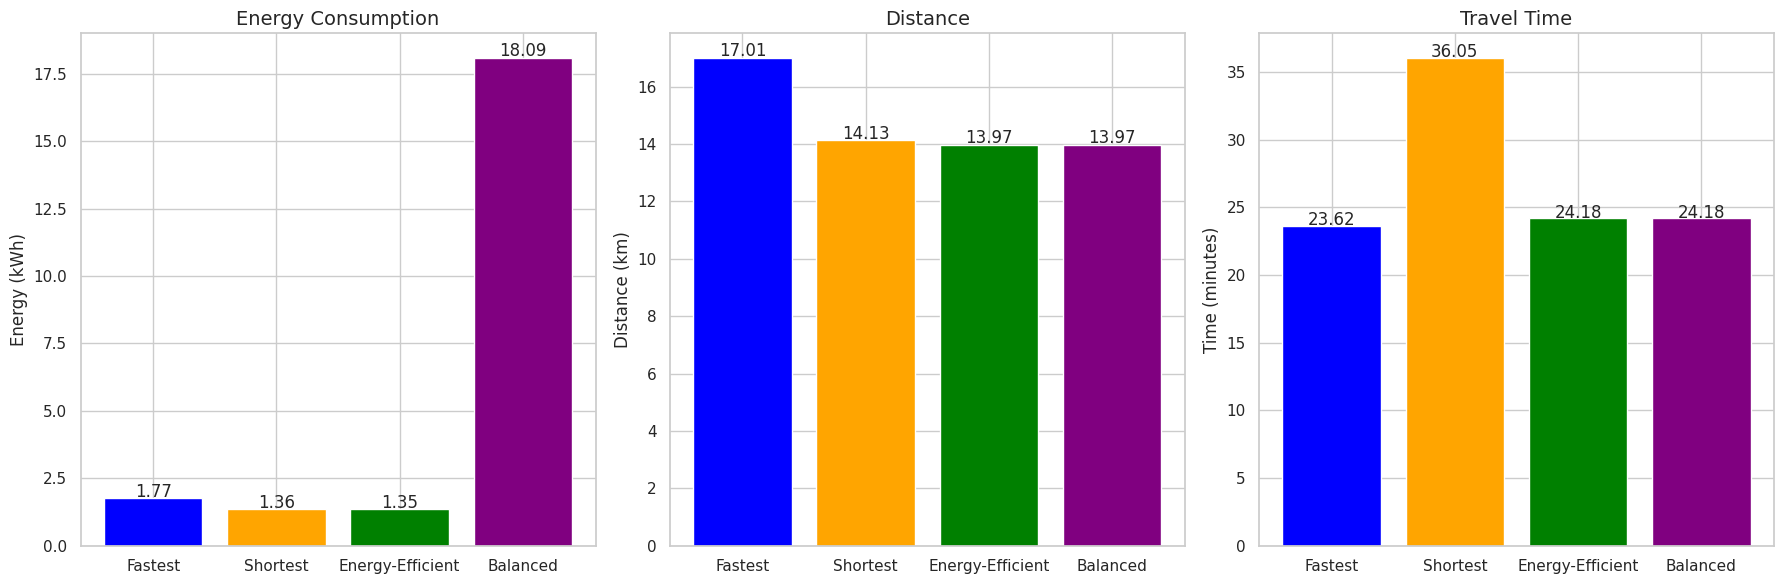

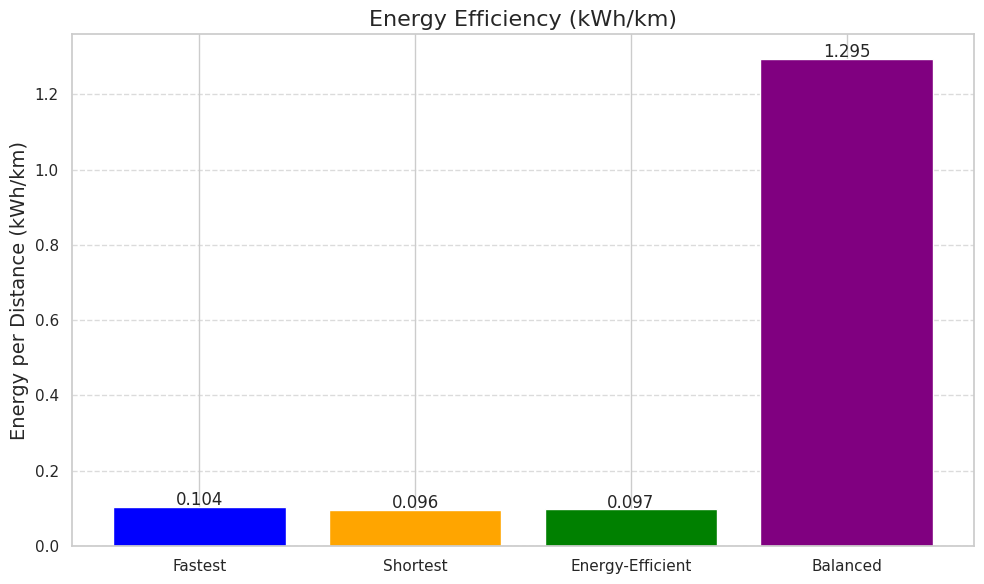


=== Route Comparison Summary ===
Energy-efficient route saves 23.53% energy compared to fastest route
Energy-efficient route saves 0.62% energy compared to shortest route
Time penalty compared to fastest route: 2.38%

=== Efficiency Metrics (kWh/km) ===
Fastest: 0.1038 kWh/km
Shortest: 0.0961 kWh/km
Energy-Efficient: 0.0966 kWh/km
Balanced: 1.2948 kWh/km


In [27]:
def analyze_route_performance():
    """
    Analyze and compare the different routing strategies.
    """
    # Check if required variables exist in global scope
    required_vars = ['fastest_route', 'shortest_route', 'energy_path', 'pareto_path',
                     'energy_total', 'pareto_energy', 'fastest_segments', 'shortest_segments',
                     'energy_distance', 'energy_time', 'pareto_distance', 'pareto_time']

    missing = [var for var in required_vars if var not in globals()]
    if missing:
        print(f"Missing route data for analysis: {', '.join(missing)}")
        return

    # Use global keyword to access global variables
    global fastest_route, shortest_route, energy_path, pareto_path
    global energy_total, pareto_energy, fastest_segments, shortest_segments
    global energy_distance, energy_time, pareto_distance, pareto_time

    # Extract route metrics
    fastest_distance = fastest_route['routes'][0]['sections'][0]['summary']['length'] / 1000  # km
    fastest_time = fastest_route['routes'][0]['sections'][0]['summary']['duration'] / 60      # minutes

    shortest_distance = shortest_route['routes'][0]['sections'][0]['summary']['length'] / 1000  # km
    shortest_time = shortest_route['routes'][0]['sections'][0]['summary']['duration'] / 60      # minutes

    # Calculate energy for HERE Maps routes
    _, fastest_energy, _ = compute_energy_consumption(fastest_segments, vehicle_params)
    _, shortest_energy, _ = compute_energy_consumption(shortest_segments, vehicle_params)

    # Prepare data for visualization
    routes = ['Fastest', 'Shortest', 'Energy-Efficient', 'Balanced']
    energy_values = [fastest_energy, shortest_energy, energy_total, pareto_energy]
    distance_values = [fastest_distance, shortest_distance, energy_distance/1000, pareto_distance/1000]
    time_values = [fastest_time, shortest_time, energy_time/60, pareto_time/60]

    # Energy savings
    energy_savings_fastest = (fastest_energy - energy_total) / fastest_energy * 100
    energy_savings_shortest = (shortest_energy - energy_total) / shortest_energy * 100

    # Create figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Energy comparison
    axs[0].bar(routes, energy_values, color=['blue', 'orange', 'green', 'purple'])
    axs[0].set_title('Energy Consumption', fontsize=14)
    axs[0].set_ylabel('Energy (kWh)', fontsize=12)
    for i, v in enumerate(energy_values):
        axs[0].text(i, v + 0.05, f"{v:.2f}", ha='center')

    # Distance comparison
    axs[1].bar(routes, distance_values, color=['blue', 'orange', 'green', 'purple'])
    axs[1].set_title('Distance', fontsize=14)
    axs[1].set_ylabel('Distance (km)', fontsize=12)
    for i, v in enumerate(distance_values):
        axs[1].text(i, v + 0.05, f"{v:.2f}", ha='center')

    # Time comparison
    axs[2].bar(routes, time_values, color=['blue', 'orange', 'green', 'purple'])
    axs[2].set_title('Travel Time', fontsize=14)
    axs[2].set_ylabel('Time (minutes)', fontsize=12)
    for i, v in enumerate(time_values):
        axs[2].text(i, v + 0.05, f"{v:.2f}", ha='center')

    plt.tight_layout()
    plt.show()

    # Create energy efficiency metrics (energy per km)
    efficiency_values = [e/d for e, d in zip(energy_values, distance_values)]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(routes, efficiency_values, color=['blue', 'orange', 'green', 'purple'])
    plt.title('Energy Efficiency (kWh/km)', fontsize=16)
    plt.ylabel('Energy per Distance (kWh/km)', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for i, v in enumerate(efficiency_values):
        plt.text(i, v + 0.005, f"{v:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n=== Route Comparison Summary ===")
    print(f"Energy-efficient route saves {energy_savings_fastest:.2f}% energy compared to fastest route")
    print(f"Energy-efficient route saves {energy_savings_shortest:.2f}% energy compared to shortest route")

    # Calculate time penalty
    time_penalty_fastest = (energy_time/60 - fastest_time) / fastest_time * 100
    print(f"Time penalty compared to fastest route: {time_penalty_fastest:.2f}%")

    # Calculate efficiency improvements
    print("\n=== Efficiency Metrics (kWh/km) ===")
    for i, route in enumerate(routes):
        print(f"{route}: {efficiency_values[i]:.4f} kWh/km")

    # Store these values for later use in the report
    globals()['fastest_energy'] = fastest_energy
    globals()['shortest_energy'] = shortest_energy
    globals()['fastest_distance'] = fastest_distance
    globals()['shortest_distance'] = shortest_distance
    globals()['fastest_time'] = fastest_time
    globals()['shortest_time'] = shortest_time

# Make sure the energy-efficient and pareto-optimal routes are computed first
print("Checking if energy paths have been computed...")
if 'energy_path' not in globals() or 'pareto_path' not in globals():
    print("Energy paths not found, computing them now...")

    # Make sure we have the combined graph
    if 'combined_graph' not in globals():
        print("Missing combined graph, can't compute energy paths.")
    else:
        # Convert string coordinates to tuples if needed
        origin_coords = tuple(map(float, origin.split(','))) if isinstance(origin, str) else origin
        destination_coords = tuple(map(float, destination.split(','))) if isinstance(destination, str) else destination

        # Find pure energy-efficient route
        print("Computing energy-efficient route...")
        energy_path, energy_total, energy_distance, energy_time = energy_efficient_route_finder(
            combined_graph, origin_coords, destination_coords
        )

        # Find balanced Pareto-optimal route (equal weight to energy and time)
        print("Computing balanced Pareto-optimal route...")
        pareto_path, pareto_energy, pareto_distance, pareto_time = pareto_optimal_route_finder(
            combined_graph, origin_coords, destination_coords, alpha=0.5
        )

        # Print results
        if energy_path and pareto_path:
            print("\n=== Energy-Efficient Route ===")
            print(f"Energy: {energy_total:.5f} kWh")
            print(f"Distance: {energy_distance/1000:.2f} km")
            print(f"Time: {energy_time/60:.2f} min")

            print("\n=== Balanced Route (Energy + Time) ===")
            print(f"Energy: {pareto_energy:.5f} kWh")
            print(f"Distance: {pareto_distance/1000:.2f} km")
            print(f"Time: {pareto_time/60:.2f} min")

# Run the analysis
try:
    # List available variables for debugging
    print("\nAvailable variables for analysis:")
    for var in ['fastest_route', 'shortest_route', 'energy_path', 'pareto_path',
                'energy_total', 'pareto_energy', 'energy_distance', 'energy_time']:
        print(f"{var} exists: {var in globals()}")

    # Try to run the analysis
    analyze_route_performance()
except Exception as e:
    print(f"Error in route analysis: {str(e)}")
    import traceback
    traceback.print_exc()

In [32]:
def generate_energy_saving_report():
    """
    Generate a comprehensive energy saving report.
    """
    if not all(var in globals() for var in ['fastest_energy', 'shortest_energy', 'energy_total', 'pareto_energy']):
        print("Missing energy data for report")
        return

    # Calculate savings
    energy_savings_fastest = (fastest_energy - energy_total)
    energy_savings_shortest = (shortest_energy - energy_total)

    energy_savings_pct_fastest = (energy_savings_fastest / fastest_energy) * 100
    energy_savings_pct_shortest = (energy_savings_shortest / shortest_energy) * 100

    # Calculate range extension
    # Assuming average EV consumption of 0.2 kWh/km and battery capacity from vehicle params
    avg_range = vehicle_params['battery_capacity'] / 0.2  # km on a full charge

    range_ext_fastest = (energy_savings_fastest / fastest_energy) * avg_range
    range_ext_shortest = (energy_savings_shortest / shortest_energy) * avg_range

    # Create styled HTML report
    report_html = f"""
    <div style="background-color:#ffffff; padding:30px; border-radius:12px; border:1px solid #ced4da; font-family: 'Arial', sans-serif; max-width: 900px; margin: auto; box-shadow: 0px 4px 12px rgba(0,0,0,0.15);">

    <!-- Report Header -->
    <h2 style="color:#155724; text-align:center; font-size:28px; margin-bottom:10px;">🚗 EV Energy Saving Report</h2>
    <hr style="border-top:2px solid #adb5bd;">

    <!-- Route Summary -->
    <div style="margin: 25px 0;">
        <h3 style="color:#212529; font-size:22px; margin-bottom:15px;">📍 Route Summary</h3>
        <table style="width:100%; border-collapse:collapse; text-align:left; font-size:16px;">
            <tr style="border-bottom:2px solid #adb5bd; background-color:#495057; color:#ffffff;">
                <th style="padding:12px;">Route</th>
                <th style="padding:12px; text-align:right;">Energy (kWh)</th>
                <th style="padding:12px; text-align:right;">Distance (km)</th>
                <th style="padding:12px; text-align:right;">Time (min)</th>
                <th style="padding:12px; text-align:right;">Efficiency (kWh/km)</th>
            </tr>
            <tr style="border-bottom:1px solid #ced4da; background-color:#f8f9fa; color:#212529;">
                <td style="padding:12px;">Fastest Route</td>
                <td style="padding:12px; text-align:right;">{fastest_energy:.3f}</td>
                <td style="padding:12px; text-align:right;">{fastest_distance:.2f}</td>
                <td style="padding:12px; text-align:right;">{fastest_time:.2f}</td>
                <td style="padding:12px; text-align:right;">{fastest_energy/fastest_distance:.4f}</td>
            </tr>
            <tr style="border-bottom:1px solid #adb5bd; background-color:#e9ecef; color:#212529;">
                <td style="padding:12px;">Shortest Route</td>
                <td style="padding:12px; text-align:right;">{shortest_energy:.3f}</td>
                <td style="padding:12px; text-align:right;">{shortest_distance:.2f}</td>
                <td style="padding:12px; text-align:right;">{shortest_time:.2f}</td>
                <td style="padding:12px; text-align:right;">{shortest_energy/shortest_distance:.4f}</td>
            </tr>
            <tr style="border-bottom:2px solid #adb5bd; background-color:#28a745; color:#ffffff; font-weight:bold;">
                <td style="padding:12px;">⚡ Energy-Efficient Route</td>
                <td style="padding:12px; text-align:right;">{energy_total:.3f}</td>
                <td style="padding:12px; text-align:right;">{energy_distance/1000:.2f}</td>
                <td style="padding:12px; text-align:right;">{energy_time/60:.2f}</td>
                <td style="padding:12px; text-align:right;">{energy_total/(energy_distance/1000):.4f}</td>
            </tr>
            <tr style="border-bottom:1px solid #adb5bd; background-color:#f8f9fa; color:#212529;">
                <td style="padding:12px;">⚖️ Balanced Route</td>
                <td style="padding:12px; text-align:right;">{pareto_energy:.3f}</td>
                <td style="padding:12px; text-align:right;">{pareto_distance/1000:.2f}</td>
                <td style="padding:12px; text-align:right;">{pareto_time/60:.2f}</td>
                <td style="padding:12px; text-align:right;">{pareto_energy/(pareto_distance/1000):.4f}</td>
            </tr>
        </table>
    </div>

    <!-- Energy Savings & Range Extension -->
    <div style="display:flex; gap:15px; margin: 30px 0;">
        <!-- Energy Savings -->
        <div style="flex:1; background-color:#495057; padding:20px; border-radius:10px; box-shadow: 2px 2px 5px rgba(0,0,0,0.15); color:#ffffff;">
            <h3 style="font-size:20px;">⚡ Energy Savings</h3>
            <p><b>Compared to fastest route:</b> <span style="color:#28a745;">{energy_savings_fastest:.3f} kWh</span> ({energy_savings_pct_fastest:.1f}%)</p>
            <p><b>Compared to shortest route:</b> <span style="color:#28a745;">{energy_savings_shortest:.3f} kWh</span> ({energy_savings_pct_shortest:.1f}%)</p>
            <p style="font-size:14px; color:#e9ecef;"><i>Data modeled from De Nunzio et al. (2016).</i></p>
        </div>

        <!-- Range Extension -->
        <div style="flex:1; background-color:#212529; padding:20px; border-radius:10px; box-shadow: 2px 2px 5px rgba(0,0,0,0.15); color:#ffffff;">
            <h3 style="font-size:20px;">🔋 Range Extension</h3>
            <p>With a battery capacity of <b>{vehicle_params['battery_capacity']} kWh</b>:</p>
            <p><b>Extended range vs fastest:</b> <span style="color:#17a2b8;">{range_ext_fastest:.2f} km</span></p>
            <p><b>Extended range vs shortest:</b> <span style="color:#17a2b8;">{range_ext_shortest:.2f} km</span></p>
            <p style="font-size:14px; color:#adb5bd;"><i>Assuming an average consumption of 0.2 kWh/km.</i></p>
        </div>
    </div>

    <!-- Footer -->
    <hr style="border-top:2px solid #adb5bd;">
    <p style="text-align:center; font-style:italic; color:#495057; font-size:14px;">
        This energy-efficient routing strategy is based on the model proposed by De Nunzio et al. (2016).<br>
        Implementation includes terrain modeling, traffic conditions, road networks, and custom optimization.
    </p>
</div>


    """

    display(HTML(report_html))

# Generate the report
try:
    generate_energy_saving_report()
except Exception as e:
    print(f"Error generating report: {e}")
    import traceback
    traceback.print_exc()


Route,Energy (kWh),Distance (km),Time (min),Efficiency (kWh/km)
Fastest Route,1.765,17.01,23.62,0.1038
Shortest Route,1.358,14.13,36.05,0.0961
⚡ Energy-Efficient Route,1.350,13.97,24.18,0.0966
⚖️ Balanced Route,18.089,13.97,24.18,1.2948
